In [1]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/\(데이콘\)운동동작분류/data ./

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D, MaxPool1D, SeparableConv1D, AvgPool1D, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Flatten, Activation, Dropout, BatchNormalization, Input, Add, GlobalAvgPool1D, Subtract, Reshape, Concatenate, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import signal
from tqdm import tqdm

In [3]:
df = pd.read_csv('./data/train_features.csv')
train_x = df.values[:,2:].reshape(-1,600,6)
print(train_x.shape)
# df

(3125, 600, 6)


In [4]:
df = pd.read_csv('./data/train_labels.csv')
train_y = df.values[:,1].astype(np.int8)
print(train_y.shape)
# df

(3125,)


In [5]:
df = pd.read_csv('./data/test_features.csv')
test = df.values[:,2:].reshape(-1,600,6)
print(test.shape)
# df

(782, 600, 6)


In [6]:
def show_data(x, label):
  print(label)
  data = x
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(data[:,0], label='acc_x')
  ax1.plot(data[:,1], label='acc_y')
  ax1.plot(data[:,2], label='acc_z')
  ax1.grid()
  ax1.legend()
  ax2.plot(data[:,3], label='gy_x')
  ax2.plot(data[:,4], label='gy_y')
  ax2.plot(data[:,5], label='gy_z')
  ax2.grid()
  ax2.legend()

  plt.show()

In [7]:
def get_period(data_x): # (6)
  periods = []
  ch = data_x.shape[1]
  top_n = 3

  for i in range(ch):
    f, Pxx = signal.periodogram(data_x[:,i])
    freq_indices = np.flip(np.argsort(Pxx), 0)[0:top_n]
    freq = f[freq_indices]
    period = np.around(1 / np.array(freq))
    periods.append(period.tolist())
  
  periods = np.array(periods, dtype=np.int).swapaxes(0,1) # (3, ch)
  
  wei = []
  for i in range(top_n):
    wei += [0.8**i] * ch

  pers = []
  cnt = np.bincount(periods.reshape(-1), weights=wei)#[1]*ch + [0.8]*ch + [0.5]*ch)
  for i in range(3):
    per = np.argmax(cnt)
    pers.append(per)
    cnt[per] = 0

  return pers

In [8]:
def longer(X, size):
  assert len(X) < size

  ind = np.arange(len(X))
  ind = np.around(ind/ind[-1] * (size-1)).astype(int)

  if len(X.shape) == 2:
    temp = np.zeros((size, X.shape[1]))
  elif len(X.shape) == 1:
    temp = np.zeros((size))
  
  for i in range(len(X)-1):
    gap = ind[i+1] - ind[i]
    temp[ind[i]:ind[i+1]] = np.linspace(X[i], X[i+1], gap, endpoint=False)
  temp[-1] = X[-1]
  return temp

In [9]:
def get_pers_wise_data(data_x, data_y, mode='train'):
  assert len(data_x.shape) == 3
  assert len(data_y.shape) == 1
  new_data_x = []
  new_data_y = []

  for i in tqdm(range(len(data_x))):
    pers = get_period(data_x[i])[0]
    if 30 < pers < 300:
      x, y = one_get_pers_wise_data(data_x[i], data_y[i], pers, mode)
      new_data_x += x.tolist()
      new_data_y += y.tolist()
    else:
      new_data_x += data_x[i:i+1].tolist()
      new_data_y += data_y[i:i+1].tolist()
  
  new_data_x = np.array(new_data_x)
  new_data_y = np.array(new_data_y)
  print(len(new_data_x))
  print(len(new_data_y))

  shuffle_idx = np.arange(len(new_data_x))
  if mode == 'train' : np.random.shuffle(shuffle_idx)

  return new_data_x[shuffle_idx], new_data_y[shuffle_idx]

def one_get_pers_wise_data(one_x, one_y, pers, mode='train'):
  assert len(one_x.shape) == 2
  if mode == 'train' : DA_size = 5
  else :               DA_size = 1
  many_x = []

  for i in range(DA_size):
    if mode == 'train' : rand_val = np.random.randint(100,600-pers)
    else :               rand_val = 100
    many_x += longer(get_avg_pers_data(one_x, rand_val, pers), 600)[np.newaxis,:,:].tolist()

  many_y = [one_y] * DA_size

  return np.array(many_x), np.array(many_y)

def get_avg_pers_data(one_x, loc, pers):
  num = (600 - loc) // pers
  temp = np.zeros((num, pers, one_x.shape[-1]))

  for i in range(num):
    temp[i, :, :] = one_x[loc+pers*i:loc+pers*(i+1)]
  
  return np.mean(temp, axis=0)

In [10]:
DA_perswise_train_x, DA_perswise_train_y = get_pers_wise_data(train_x, train_y, mode='train')
print(DA_perswise_train_x.shape)
print(DA_perswise_train_y.shape)

100%|██████████| 3125/3125 [00:39<00:00, 79.78it/s]


9565
9565
(9565, 600, 6)
(9565,)


In [11]:
DA_perswise_test, _ = get_pers_wise_data(test, np.arange(len(test)), mode='test')
print(DA_perswise_test.shape)

100%|██████████| 782/782 [00:02<00:00, 265.00it/s]


782
782
(782, 600, 6)


In [12]:
DA_perswise_train_x[:,:,3:] /= 100
acc_std = np.std(DA_perswise_train_x[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(DA_perswise_train_x[:,:,3:], axis=-1).reshape(-1, 600, 1)
DA_perswise_train_x = np.concatenate([DA_perswise_train_x, acc_std, gy_std], axis=-1)

DA_perswise_test[:,:,3:] /= 100
acc_std = np.std(DA_perswise_test[:,:,:3], axis=-1).reshape(-1, 600, 1)
gy_std = np.std(DA_perswise_test[:,:,3:], axis=-1).reshape(-1, 600, 1)
DA_perswise_test = np.concatenate([DA_perswise_test, acc_std, gy_std], axis=-1)

print(DA_perswise_train_x.shape)
print(DA_perswise_test.shape)

(9565, 600, 8)
(782, 600, 8)


In [13]:
def conv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, bn = True):
    x = Conv1D(filters, kernel_size, padding=padding, strides=strides, kernel_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

def sepconv1d_bn(x, filters, kernel_size, padding='same', strides=1, activation='elu', weight_decay=1e-5, depth_multiplier=1, bn = True):
    x = SeparableConv1D(filters, kernel_size, padding=padding, strides=strides, depth_multiplier=depth_multiplier, depthwise_regularizer=l2(weight_decay), pointwise_regularizer=l2(weight_decay))(x)
    if bn: x = BatchNormalization()(x)
    if activation: x = Activation(activation)(x)
    return x

In [17]:
model_input = Input(shape=(600,8))
x = model_input

res = conv1d_bn(x, 64, 1, strides=2, activation=None)
x = conv1d_bn(x, 64, 3, activation='elu')
x = conv1d_bn(x, 64, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 128, 1, strides=2, activation=None)
x = conv1d_bn(x, 128, 3, activation='elu')
x = conv1d_bn(x, 128, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 256, 1, strides=2, activation=None)
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation='elu')
x = conv1d_bn(x, 256, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

res = conv1d_bn(x, 512, 1, strides=2, activation=None)
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation='elu')
x = conv1d_bn(x, 512, 3, activation=None)
x = MaxPool1D(pool_size=2, strides=2, padding='same')(x)
x = Add()([x, res])
x = Activation('elu')(x)

x = GlobalAvgPool1D()(x)

# x = Dropout(0.4)(x)

model_output = Dense(61, activation="softmax")(x)

model = Model(model_input, model_output)

optimizer = SGD(lr=0.001, momentum=0.9)
# model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
model.compile(optimizer, loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer, loss=[focal_loss], metrics=['acc'])
# model.summary()

In [15]:
def lr_scheduler(epoch, lr):
  if epoch < 5:# or epoch > 60:
    print('LR : ', lr)
    return lr
  else:
    lr *= 0.95
    print('LR : ', lr)
    return lr

callback1 = LearningRateScheduler(lr_scheduler)

In [18]:
history = model.fit(
    DA_perswise_train_x, to_categorical(DA_perswise_train_y, num_classes=61), 
    validation_split=0, epochs=70, batch_size=12, initial_epoch=0, callbacks=[callback1])

Epoch 1/70
LR :  0.0010000000474974513
798/798 [==============================] - 16s 15ms/step - loss: 2.3223 - acc: 0.4344
Epoch 2/70
LR :  0.0010000000474974513
798/798 [==============================] - 12s 15ms/step - loss: 1.3914 - acc: 0.6142
Epoch 3/70
LR :  0.0010000000474974513
798/798 [==============================] - 12s 15ms/step - loss: 1.2065 - acc: 0.6575
Epoch 4/70
LR :  0.0010000000474974513
798/798 [==============================] - 12s 15ms/step - loss: 1.0562 - acc: 0.6994
Epoch 5/70
LR :  0.0010000000474974513
798/798 [==============================] - 12s 15ms/step - loss: 1.0151 - acc: 0.6948
Epoch 6/70
LR :  0.0009500000451225787
798/798 [==============================] - 12s 15ms/step - loss: 0.9073 - acc: 0.7292
Epoch 7/70
LR :  0.0009025000152178108
798/798 [==============================] - 12s 15ms/step - loss: 0.8397 - acc: 0.7554
Epoch 8/70
LR :  0.0008573750033974647
798/798 [==============================] - 12s 15ms/step - loss: 0.8079 - acc: 0.7628


In [ ]:
def show_history(history, start=0):
  fig = plt.figure(figsize=(14,5))
  ax1 = fig.add_subplot(1, 2, 1)
  ax2 = fig.add_subplot(1, 2, 2)
  ax1.plot(history.history['loss'][start:], label='loss')
  ax1.plot(history.history['val_loss'][start:], label='val_loss')
  ax1.grid()
  ax1.legend()
  ax2.plot(history.history['acc'][start:], label='acc')
  ax2.plot(history.history['val_acc'][start:], label='val_acc')
  ax2.grid()
  ax2.legend()

  plt.show()

show_history(history)

In [20]:
for i in range(30):
  temp = model.predict(DA_perswise_train_x)
  # failure_ind = np.where((np.max(temp, axis=1) < 0.7) | (np.argmax(temp, axis=1) != train_y))[0]
  losses = tf.keras.metrics.categorical_crossentropy(to_categorical(DA_perswise_train_y, num_classes=61), temp).numpy()
  mean_loss = np.mean(losses)
  # failure_ind = np.where(losses > mean_loss * 2)[0]
  failure_ind = np.where(losses > 0.4)[0]

  print()
  print('mean_loss : ', mean_loss)
  print(len(failure_ind))
  # print(failure_ind)
  failure_train_x = DA_perswise_train_x[failure_ind]
  failure_train_y = DA_perswise_train_y[failure_ind]
  failure_train_x, failure_train_y = np.concatenate([DA_perswise_train_x, failure_train_x], axis=0), np.concatenate([DA_perswise_train_y, failure_train_y], axis=0)
  mix_idx = np.arange(len(failure_train_x))
  np.random.shuffle(mix_idx)
  failure_train_x, failure_train_y = failure_train_x[mix_idx], failure_train_y[mix_idx]


  model.fit(
      failure_train_x, to_categorical(failure_train_y, num_classes=61), 
      epochs=71+i, batch_size=12, initial_epoch=70+i, callbacks=[callback1])



mean_loss :  0.13562757
814
Epoch 71/71
LR :  3.3865528712340166e-05
865/865 [==============================] - 13s 15ms/step - loss: 0.3167 - acc: 0.9118

mean_loss :  0.12639605
764
Epoch 72/72
LR :  3.217225348635111e-05
861/861 [==============================] - 13s 15ms/step - loss: 0.3195 - acc: 0.9123

mean_loss :  0.12879406
817
Epoch 73/73
LR :  3.0563641848857516e-05
866/866 [==============================] - 14s 16ms/step - loss: 0.3210 - acc: 0.9138

mean_loss :  0.12772873
813
Epoch 74/74
LR :  2.9035460102022626e-05
865/865 [==============================] - 14s 16ms/step - loss: 0.3162 - acc: 0.9114

mean_loss :  0.12484479
754
Epoch 75/75
LR :  2.7583687096921494e-05
860/860 [==============================] - 13s 16ms/step - loss: 0.3137 - acc: 0.9145

mean_loss :  0.12977958
815
Epoch 76/76
LR :  2.620450213726144e-05
865/865 [==============================] - 14s 14ms/step - loss: 0.3149 - acc: 0.9144

mean_loss :  0.12775013
778
Epoch 77/77
LR :  2.4894276339182395e

In [22]:
df = pd.read_csv('./data/sample_submission.csv')
yhat = model.predict(DA_perswise_test)
df.iloc[:,1:] = yhat
df.to_csv('submission31.csv', index=False)
df

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.030167,1.061571e-05,6.297546e-04,0.000069,0.000562,8.876864e-07,1.054813e-05,1.314946e-05,7.511314e-07,1.223743e-01,0.005075,1.421590e-01,3.067654e-05,9.853993e-02,3.929200e-06,0.000280,6.969651e-05,5.337417e-06,5.311824e-06,1.484904e-05,8.249624e-06,6.364303e-05,3.701425e-04,4.087172e-03,4.139784e-01,1.619999e-06,0.003061,4.794533e-06,4.642069e-06,7.501797e-06,2.561337e-03,2.106882e-02,0.000036,5.461646e-06,0.000092,8.786747e-06,9.513233e-04,1.840040e-05,3.258293e-05,1.906051e-05,2.287376e-05,1.076182e-06,5.206430e-05,7.728772e-07,2.266365e-06,4.808137e-06,4.356578e-05,1.087170e-05,0.000003,0.000430,0.000422,9.867821e-04,1.697351e-04,5.821643e-04,8.440496e-05,3.358400e-04,1.207036e-05,0.000045,1.503734e-01,2.630341e-06,0.000012
1,3126,0.001885,5.410200e-05,2.604944e-06,0.000941,0.000033,3.119950e-04,1.033813e-05,1.163387e-06,6.181795e-07,2.331122e-05,0.000006,5.845796e-06,6.860867e-07,5.350435e-06,1.586130e-05,0.000079,2.493223e-05,2.306360e-05,4.598971e-06,4.806425e-06,2.250668e-05,7.272323e-05,7.029236e-05,7.456042e-05,1.797006e-05,9.549683e-05,0.990837,1.279866e-04,5.103890e-07,1.193854e-05,4.849840e-06,9.483390e-06,0.001887,3.166818e-05,0.000044,1.992608e-04,8.475591e-06,3.925780e-07,1.109447e-05,1.643684e-05,1.960741e-04,1.806938e-05,3.583097e-06,6.012674e-06,3.384172e-06,1.578537e-05,1.379445e-05,1.006133e-04,0.000871,0.000261,0.000342,8.777087e-06,1.337011e-06,2.633221e-06,2.050061e-04,1.139683e-05,4.728827e-06,0.000064,7.094350e-06,1.621014e-04,0.000724
2,3127,0.000621,2.329437e-04,1.089500e-05,0.000021,0.000009,5.093796e-05,4.933872e-04,1.079520e-04,3.296261e-03,8.396436e-06,0.000011,2.016042e-06,9.482585e-06,3.177856e-06,3.691304e-05,0.000003,4.508322e-04,5.129120e-06,2.449604e-07,2.149198e-07,2.737283e-07,1.426624e-05,7.384855e-08,1.443947e-07,2.560671e-06,5.222954e-04,0.062740,2.048082e-05,3.625257e-03,1.260425e-04,1.963924e-06,9.792640e-06,0.000203,2.836047e-05,0.000561,6.025146e-05,2.236335e-03,7.150575e-05,5.752042e-05,2.711741e-04,6.774841e-05,1.057406e-06,2.802352e-06,1.667988e-04,6.403164e-04,9.067893e-01,3.304396e-05,2.659768e-04,0.012153,0.002121,0.000960,4.713811e-06,1.784454e-05,8.053309e-06,3.925335e-05,6.544373e-06,1.431994e-05,0.000013,1.453728e-05,3.231872e-05,0.000722
3,3128,0.000209,4.617720e-05,6.200556e-05,0.000044,0.000005,2.142560e-04,1.232819e-06,4.531015e-05,7.446647e-06,5.863456e-07,0.000027,1.288454e-06,2.809802e-07,3.549587e-06,1.474670e-06,0.000008,5.355413e-05,3.028532e-06,5.331078e-06,9.982401e-07,1.028842e-06,4.267330e-05,5.133000e-05,6.395945e-06,1.659844e-04,1.388671e-06,0.983800,1.600937e-05,3.164927e-06,1.556115e-06,3.928205e-07,3.371264e-05,0.000534,1.711052e-03,0.000118,2.527260e-04,6.671004e-07,5.941584e-06,6.106151e-06,5.203181e-06,1.211304e-05,2.813772e-03,7.263869e-05,7.164896e-03,1.456312e-05,1.739729e-06,5.941845e-06,9.184668e-07,0.000004,0.000982,0.000476,2.530233e-06,1.609833e-06,2.552282e-06,1.512184e-04,1.825177e-04,1.388790e-05,0.000473,1.037884e-04,8.054357e-06,0.000015
4,3129,0.000036,3.245188e-09,2.209914e-08,0.000013,0.000001,1.112307e-05,3.057490e-07,3.101363e-08,5.662067e-07,1.384371e-06,0.000002,5.556733e-07,4.421997e-08,4.809070e-07,1.960629e-05,0.000230,9.102384e-08,3.635223e-08,3.186780e-06,2.539818e-07,5.535348e-07,2.552987e-07,3.043410e-05,6.194176e-06,2.858724e-06,5.051816e-07,0.992870,1.860866e-09,3.750641e-07,2.586431e-07,3.238690e-08,1.948453e-07,0.000370,7.800769e-06,0.000062,1.280231e-07,1.380675e-05,5.339553e-09,1.578063e-07,8.898101e-06,1.231422e-08,7.403640e-07,9.404055e-07,1.735030e-06,2.122037e-08,1.308234e-07,3.524410e-07,7.332097e-07,0.000727,0.001178,0.003305,7.871985e-07,6.979931e-08,7.829298e-08,2.783339e-08,5.365804e-08,3.584281e-08,0.000811,5.866175e-07,5.980615e-07,0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

-1


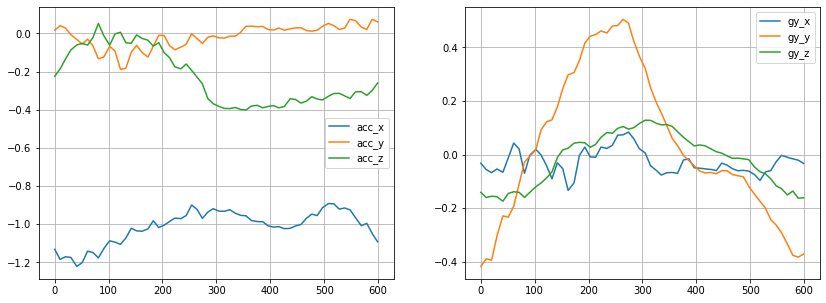

In [26]:
show_data(DA_perswise_test[0], -1)

In [38]:
np.where(DA_perswise_train_y==11)

(array([  57,   92,  326,  434,  491,  550,  575,  773, 1008, 1181, 1483,
        1646, 1681, 1922, 1944, 2013, 2095, 2122, 2188, 2292, 2298, 2379,
        2442, 2466, 2547, 2668, 3000, 3024, 3199, 3250, 3350, 3376, 3462,
        3539, 3666, 3684, 3716, 3828, 3914, 3994, 4100, 4107, 4111, 4125,
        4365, 4433, 4527, 4610, 4671, 4675, 4741, 5059, 5104, 5144, 5182,
        5275, 5286, 5350, 5431, 5487, 5868, 5873, 5892, 6110, 6113, 6121,
        6215, 6235, 6408, 6465, 6541, 6544, 6557, 6565, 6695, 6782, 6843,
        6863, 6997, 7025, 7030, 7036, 7449, 7450, 7768, 7781, 7876, 7879,
        8100, 8123, 8172, 8243, 8309, 8352, 8504, 8519, 8570, 8573, 8780,
        8897, 8941, 9124, 9169, 9241, 9349, 9364, 9479]),)

-1


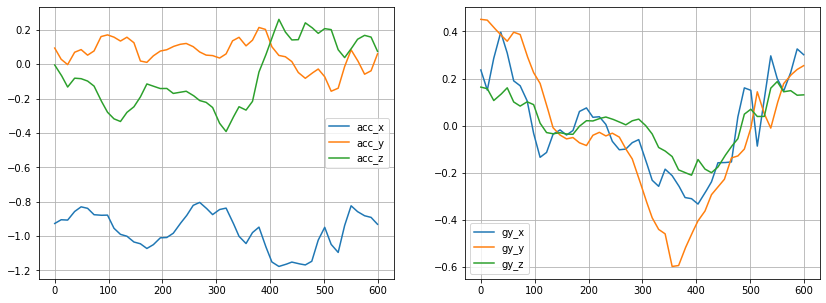

In [44]:
show_data(DA_perswise_train_x[6997], -1)